# Make a simulation immitating the distribution of IWIs from the DHS

In [1]:
import os
import configparser
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

sns.set_theme()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read config file
config = configparser.ConfigParser()
config.read('../config.ini')

DATA_DIR = config['PATHS']['DATA_DIR']

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(os.path.join(DATA_DIR, 'dhs_with_imgs.csv'))
df

,cluster_id,lon,lat,rural,region_id,country,survey,month,year,iwi
0,AO.Bengo.71.135,13.640789,-8.589805,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,62.334459
1,AO.Bengo.71.158,14.122619,-7.718385,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,2,2016,8.226589
2,AO.Bengo.71.169,13.654425,-8.592545,False,AO.Bengo,Angola,Angola 2015-16 Standard DHS,10,2015,62.760211
3,AO.Bengo.71.203,13.517859,-8.652260,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,1,2016,68.211697
4,AO.Bengo.71.208,13.721998,-7.852511,True,AO.Bengo,Angola,Angola 2015-16 Standard DHS,11,2015,14.825944
...,...,...,...,...,...,...,...,...,...,...
68614,ZW.Midlands.72.37,30.008579,-20.911177,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,9,2015,27.791567
68615,ZW.Midlands.72.52,29.860028,-20.402214,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,36.929878
68616,ZW.Midlands.72.69,30.172833,-20.724753,True,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,10,2015,24.406326
68617,ZW.Midlands.72.91,29.820084,-19.453466,False,ZW.Midlands,Zimbabwe,Zimbabwe 2015 Standard DHS,7,2015,59.887344


In [4]:
rural_survey = df.groupby(['survey', 'region_id', 'rural'])

# Filter out surveys with less than 2 samples
filtered = rural_survey.filter(lambda x: x['iwi'].count() > 2)

means = filtered.groupby(['survey', 'region_id', 'rural'])['iwi'].mean()
stds = filtered.groupby(['survey', 'region_id', 'rural'])['iwi'].std()
counts = filtered.groupby(['survey', 'region_id', 'rural'])['iwi'].count()
weights = counts / counts.sum()

In [5]:
weights

survey                      region_id                 rural
Angola 2006-07 MIS          AO.Hiper Endemica         False    0.000073
                                                      True     0.000366
                            AO.Instavel Mesoendemica  False    0.000102
                                                      True     0.000278
                            AO.Luanda                 False    0.000439
                                                                 ...   
Zimbabwe 2015 Standard DHS  ZW.Matabeleland North     True     0.000380
                            ZW.Matabeleland South     False    0.000161
                                                      True     0.000366
                            ZW.Midlands               False    0.000234
                                                      True     0.000366
Name: iwi, Length: 2973, dtype: float64

In [6]:
from scipy.stats import norm

class MixtureOfGaussians:
    def __init__(self, component_weights, component_means, component_std_devs):

        self.component_weights = component_weights
        self.component_means = component_means
        self.component_std_devs = component_std_devs

    def pdf(self, y_hat):
        pdf_value = 0
        for i in range(len(self.component_weights)):
            pdf_value += self.component_weights[i] * norm.pdf(y_hat, loc=self.component_means[i], scale=self.component_std_devs[i])
        return pdf_value
        
    def sample(self, num_samples):

        component_choices = np.random.choice(len(self.component_weights), size=num_samples, p=self.component_weights)
        samples = np.array([np.random.normal(self.component_means[i], self.component_std_devs[i]) for i in component_choices])

        return samples

    def score(self, y_hat):
        # Compute the density at y_hat
        p_y = self.pdf(y_hat)
        # Compute the derivative of each component's density
        derivative_sum = 0
        for i in range(len(self.component_weights)):
            weight = self.component_weights[i]
            mu = self.component_means[i]
            sigma = self.component_std_devs[i]
            # Derivative of norm.pdf: -(y_hat - mu)/sigma^2 * norm.pdf
            derivative = -(y_hat - mu) / (sigma ** 2) * norm.pdf(y_hat, loc=mu, scale=sigma)
            derivative_sum += weight * derivative
        return derivative_sum / p_y

0       False
1        True
2       False
3        True
4       False
        ...  
2968     True
2969    False
2970     True
2971    False
2972     True
Name: rural, Length: 2973, dtype: bool

In [19]:
rural = weights.reset_index()['rural']
means.values[rural].mean(), means.values[~rural].mean()

(22.427819076286838, 41.1346346597944)

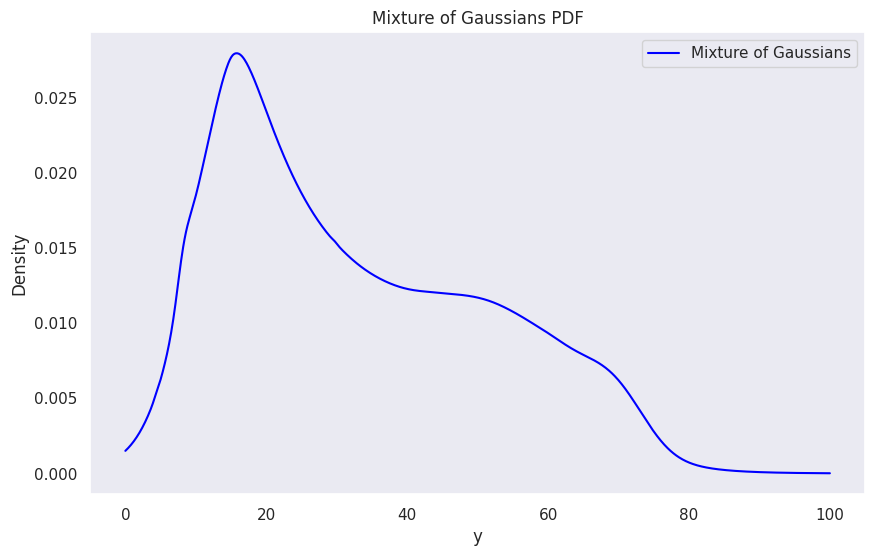

In [8]:
y_dist = MixtureOfGaussians(weights.values, means.values, stds.values)
plt.figure(figsize=(10, 6))
x = np.linspace(0, 100, 1000)
plt.plot(x, y_dist.pdf(x), label='Mixture of Gaussians', color='blue')
plt.xlabel('y')
plt.ylabel('Density')
plt.title('Mixture of Gaussians PDF')
plt.legend()
plt.grid()
plt.show()

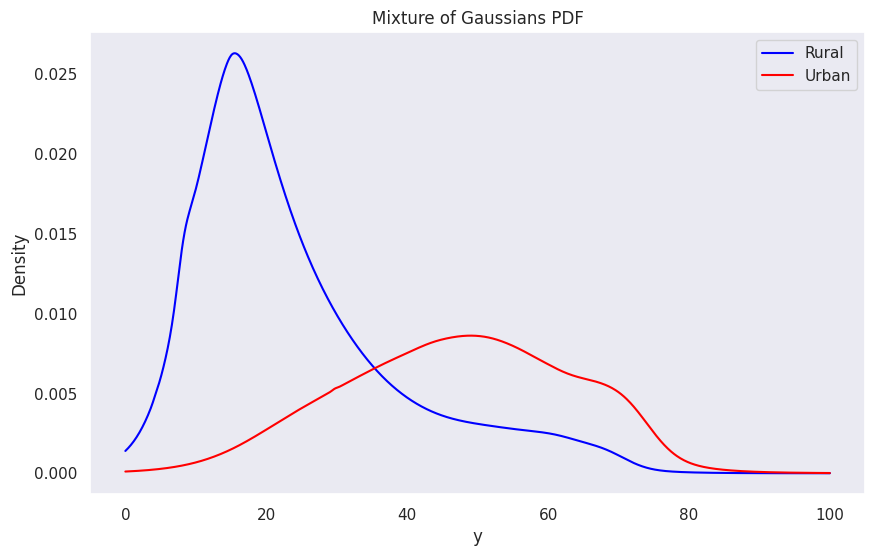

In [20]:
rural = weights.reset_index()['rural']

plt.figure(figsize=(10, 6))
plt.plot(x, MixtureOfGaussians(weights.values[rural], means.values[rural], stds.values[rural]).pdf(x), label='Rural', color='blue')
plt.plot(x, MixtureOfGaussians(weights.values[~rural], means.values[~rural], stds.values[~rural]).pdf(x), label='Urban', color='red')
plt.xlabel('y')
plt.ylabel('Density')
plt.title('Mixture of Gaussians PDF')
plt.legend()
plt.grid()
plt.show()

In [57]:
hidden_dim = 50
embedding_dim = 100
n_layers = 4

layers = []
for i in range(n_layers - 1):
    layers.append(nn.Linear(hidden_dim if i > 0 else 4, hidden_dim))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(0.2))
layers.append(nn.Linear(hidden_dim, embedding_dim))

model = nn.Sequential(*layers).to(device)

# Freeze weights
for param in model.parameters():
    param.requires_grad = False

model


Sequential(
  (0): Linear(in_features=4, out_features=50, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): Linear(in_features=50, out_features=50, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.2, inplace=False)
  (6): Linear(in_features=50, out_features=50, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.2, inplace=False)
  (9): Linear(in_features=50, out_features=100, bias=True)
)

In [58]:
x = df[['lon', 'lat', 'rural', 'iwi']].values.astype('float')

# Normalize the input features
scaler = StandardScaler()
x = scaler.fit_transform(x)

y = x[:, 3]

x_features = model(torch.tensor(x, dtype=torch.float32).to(device))
x_features = x_features.cpu().numpy()

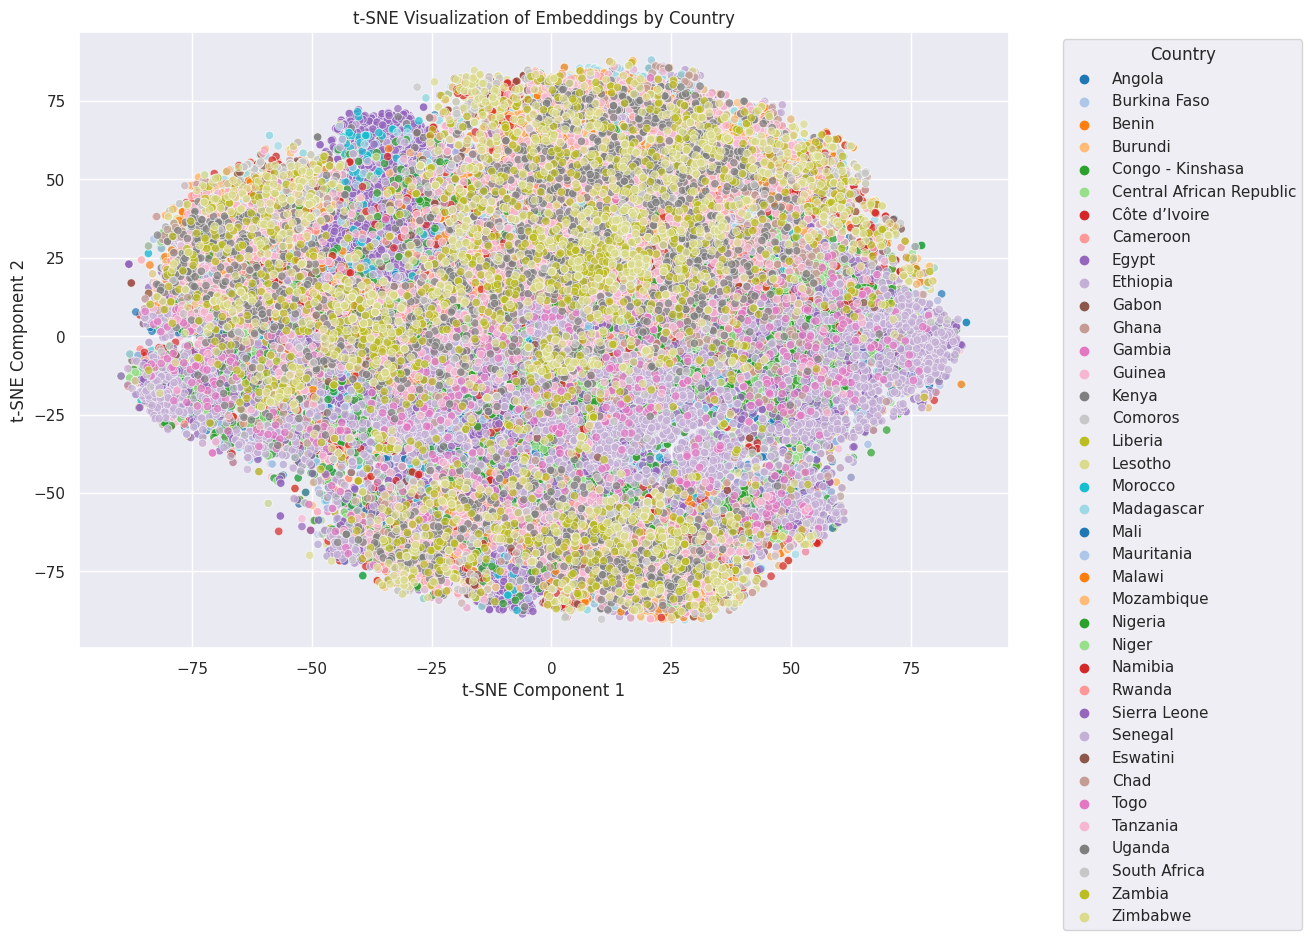

In [ ]:
from sklearn.manifold import TSNE

RANDOM_STATE = 42

# T-SNE to reduce embeddings to 2D
tsne = TSNE(n_components=2, random_state=RANDOM_STATE)
embeddings_2d = tsne.fit_transform(x_features)

df['embedding_tsne1'] = embeddings_2d[:, 0]
df['embedding_tsne2'] = embeddings_2d[:, 1]

# Plot the t-SNE embeddings, colored by country
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=df, x='embedding_tsne1', y='embedding_tsne2', 
    hue='country', palette='tab20', alpha=0.7
)
plt.title("t-SNE Visualization of Embeddings by Country")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend(title="Country", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 10/100 [00:20<03:04,  2.05s/it]

Epoch [10/100], Loss: 0.3803


 20%|██        | 20/100 [00:40<02:41,  2.02s/it]

Epoch [20/100], Loss: 0.3342


 30%|███       | 30/100 [01:00<02:21,  2.03s/it]

Epoch [30/100], Loss: 0.3408


 40%|████      | 40/100 [01:21<02:02,  2.04s/it]

Epoch [40/100], Loss: 0.2126


 50%|█████     | 50/100 [01:41<01:40,  2.01s/it]

Epoch [50/100], Loss: 0.2050


 60%|██████    | 60/100 [02:01<01:20,  2.02s/it]

Epoch [60/100], Loss: 0.2365


 70%|███████   | 70/100 [02:21<01:00,  2.02s/it]

Epoch [70/100], Loss: 0.3028


 80%|████████  | 80/100 [02:42<00:40,  2.02s/it]

Epoch [80/100], Loss: 0.2310


 90%|█████████ | 90/100 [03:02<00:20,  2.04s/it]

Epoch [90/100], Loss: 0.2544


100%|██████████| 100/100 [03:23<00:00,  2.03s/it]

Epoch [100/100], Loss: 0.2533


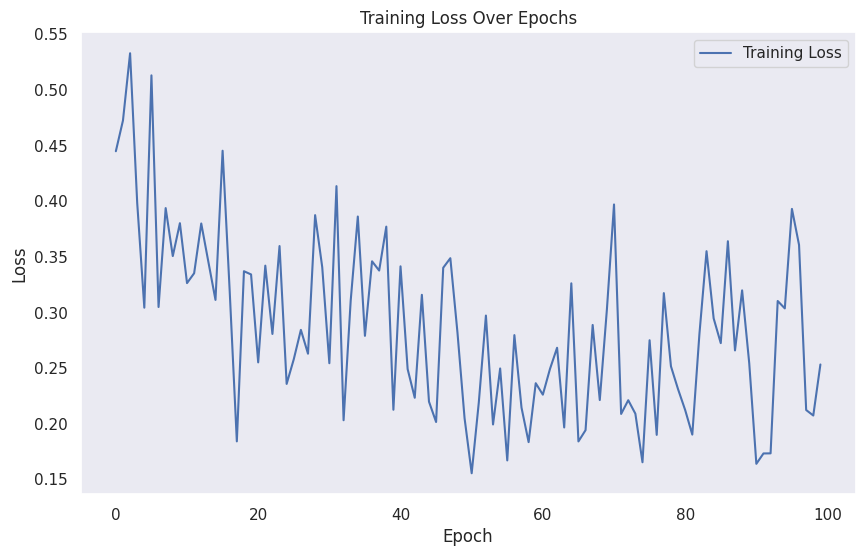

In [60]:
class EmbeddingToWealth(nn.Module):
    def __init__(self, input_dim=100, hidden_dim=50, n_layers=3):
        super(EmbeddingToWealth, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        # Define the model architecture

        layers = []
        for i in range(n_layers - 1):
            layers.append(nn.Linear(hidden_dim if i > 0 else input_dim, hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.2))
        layers.append(nn.Linear(hidden_dim, 1))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Instantiate the model
wealth_model = EmbeddingToWealth(input_dim=100, hidden_dim=50).to(device)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    x_features, y, test_size=0.2, random_state=RANDOM_STATE
)
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# Train the model
optimizer = torch.optim.Adam(wealth_model.parameters(), lr=0.001)
criterion = nn.MSELoss()
num_epochs = 100
batch_size = 32

train_losses = []
for epoch in tqdm(range(num_epochs)):
    # Forward pass with mini-batches
    for i in range(0, len(x_train_tensor), batch_size):
        x_batch = x_train_tensor[i:i + batch_size]
        y_batch = y_train_tensor[i:i + batch_size]

        # Forward pass
        y_pred = wealth_model(x_batch).squeeze()

        # Compute loss
        loss = criterion(y_pred, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_losses.append(loss.item())
    # Print loss every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Train Loss: 0.2445, Train R2: 0.7557, Train MAE: 0.3737
Test Loss: 0.2658, Test R2: 0.7332, Test MAE: 0.3868


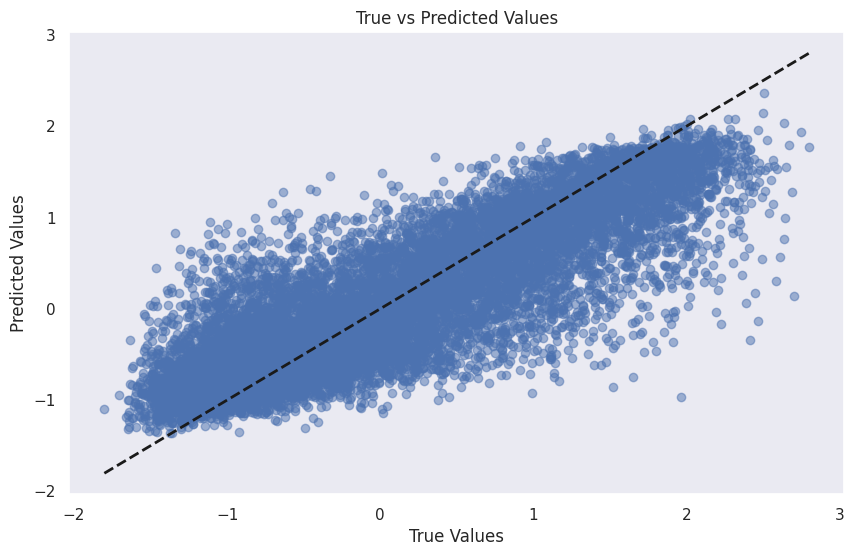

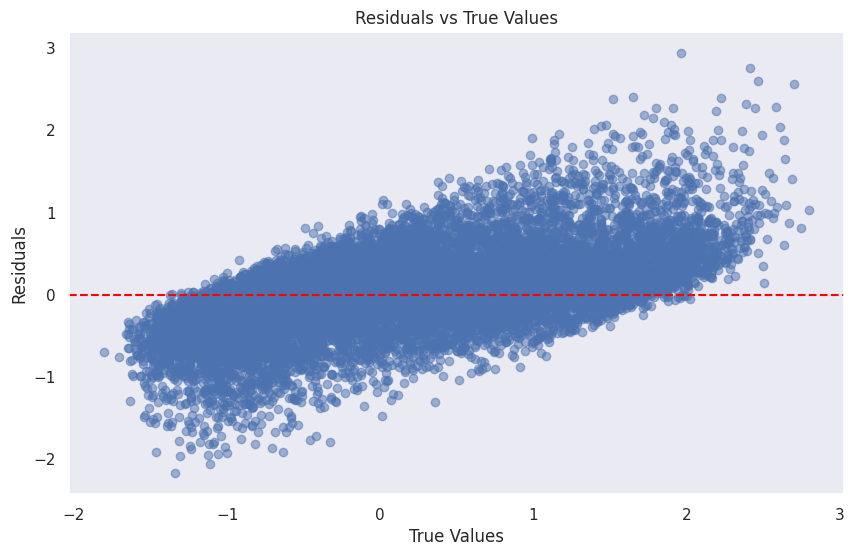

In [61]:
# Evaluate the model
with torch.no_grad():
    wealth_model.eval()
    y_train_pred = wealth_model(x_train_tensor).cpu().numpy()
    y_test_pred = wealth_model(x_test_tensor).cpu().numpy()
    y_train_pred = y_train_pred.squeeze()
    y_test_pred = y_test_pred.squeeze()
    y_train_true = y_train_tensor.cpu().numpy()
    y_test_true = y_test_tensor.cpu().numpy()
    train_loss = mean_squared_error(y_train_true, y_train_pred)
    test_loss = mean_squared_error(y_test_true, y_test_pred)
    train_r2 = r2_score(y_train_true, y_train_pred)
    test_r2 = r2_score(y_test_true, y_test_pred)
    train_mae = mean_absolute_error(y_train_true, y_train_pred)
    test_mae = mean_absolute_error(y_test_true, y_test_pred)
    print(f"Train Loss: {train_loss:.4f}, Train R2: {train_r2:.4f}, Train MAE: {train_mae:.4f}")
    print(f"Test Loss: {test_loss:.4f}, Test R2: {test_r2:.4f}, Test MAE: {test_mae:.4f}")

# Plot true vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_true, y_test_pred, alpha=0.5)
plt.plot([y_test_true.min(), y_test_true.max()], [y_test_true.min(), y_test_true.max()], 'k--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True vs Predicted Values')
plt.grid()
plt.show()

# Plot residuals
plt.figure(figsize=(10, 6))
plt.scatter(y_test_true, y_test_true - y_test_pred, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.title('Residuals vs True Values')
plt.grid()
plt.show()